In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [2]:
import sys
sys.path.append('../ptsne-pytorch')
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
cifar_train = CIFAR10(
    './data',
    train=True,
    download=True,
    transform=transform
)

cifar_test = CIFAR10(
    './data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar_test[0][0].shape

torch.Size([3, 32, 32])

In [6]:
trainloader = torch.utils.data.DataLoader(cifar_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(cifar_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(cifar_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [7]:
class Net(nn.Module):
    def __init__(self, use_cuda=False): #True
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
        self.proj_vals = {}

    def forward(self, x): # 32x32x3
        x = self.pool(F.relu(self.conv1(x))) # 28x28x6 -> 14x14x6
        self.proj_vals['conv1'] = x.view(-1, 6*14*14)
        x = self.pool(F.relu(self.conv2(x))) # 10x10x16 -> 5x5x16
        self.proj_vals['conv2'] = x.view(-1, 16*5*5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x)) # 120
        self.proj_vals['fc1'] = x.view(-1, 120)
        x = F.relu(self.fc2(x)) # 100
        self.proj_vals['fc2'] = x.view(-1, 100)
        x = self.fc3(x) # 10
        self.proj_vals['fc3'] = x.view(-1, 10)
        return x

In [8]:
class Net2(nn.Module):
    def __init__(self, use_cuda=False): # True
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(512, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
        self.proj_vals = {}

    def forward(self, x): # 32x32x3
        x = F.relu(self.conv1(x)) # 30x30x16
        self.proj_vals['conv1'] = x.view(-1, 16*30*30)
        x = F.relu(self.conv2(x)) # 28x28x32
        x = self.pool(x) # 14x14x32
        self.proj_vals['conv2'] = x.view(-1, 32*14*14)
        x = F.relu(self.conv3(x)) # 12x12x64
        x = self.pool(x) # 6x6x64
        self.proj_vals['conv3'] = x.view(-1, 64*6*6)
        x = F.relu(self.conv4(x)) # 4x4x128
        x = self.pool(x) # 2x2x128
        self.proj_vals['conv4'] = x.view(-1, 128*2*2)
        x = self.dropout(x)
        x = x.view(-1, 512)
        x = F.relu(self.dense(x)) # 10
        self.proj_vals['dense'] = x.view(-1, 10)
        return x

In [9]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(model.proj_vals[layer_key]), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion, return_accuracy=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    if return_accuracy:
        return 100. * correct / len(test_loader.dataset)


# Train Initial Network

In [10]:
epochs = 5

In [11]:
torch.manual_seed(12)
# torch.cuda.manual_seed(12)
# torch.backends.cudnn.deterministic=True

net = Net2()
# net.load_state_dict(torch.load('models/cifar-test-model.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
train_accs = []
test_accs = []
for epoch in range(epochs):
    train(200, net, 'cpu', trainloader, optimizer, criterion, epoch) #'cuda'
    #train_accs.append(test(net, 'cuda', trainloader, criterion, return_accuracy=True))
    #test_accs.append(test(net, 'cuda', testloader, criterion, return_accuracy=True))
    torch.save(net.state_dict(), 'models/cifar-before-ep{:02d}.pt'.format(epoch))

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.301891
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.131665
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.694178
Train Epoch: 0 [30000/50000 (60%)]	Loss: 1.467343
Train Epoch: 0 [40000/50000 (80%)]	Loss: 1.424962
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.424138
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.318362
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.331459
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.134089
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.103731
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.989374
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.101107
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.856099
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.789087
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.090824
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.819342
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.918969
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.149707
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.795596
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.924284
Train Epoch: 4 [0/50

In [13]:
torch.save(net.state_dict(), 'models/cifar-before.pt')

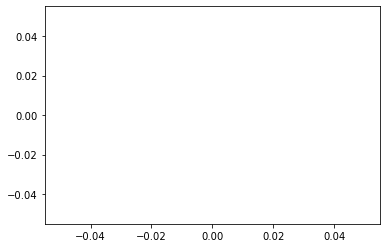

In [14]:
from matplotlib import pyplot as plt
plt.plot(train_accs)
plt.plot(test_accs)

# Embedding

In [90]:
layer_key = 'conv1' # which latent layer output should be used for embedding
embedding_size = 16*30*30 # what's the output size of this layer

In [91]:
net.load_state_dict(torch.load('models/cifar-before-ep04.pt'))

net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
        data = data#.cuda()
        out = net(data)
        logits_train.append(net.proj_vals[layer_key].detach().cpu())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
        data = data#.cuda()
        out = net(data)
        logits_test.append(net.proj_vals[layer_key].detach().cpu())
logits_test = torch.cat(logits_test)

In [92]:
import ptsne.ptsne
import importlib
importlib.reload(ptsne.ptsne)
from ptsne.ptsne import ParametricTSNE

In [93]:
ptsne = ParametricTSNE(embedding_size, 2, 100, use_cuda=False, hidden_layer_dims=[300,100], alpha=1)#alpha='learn') # use_cuda=True
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

In [94]:
torch.autograd.set_detect_anomaly(True)

In [95]:
# ptsne.fit(logits_train, pretrain=True,verbose=True)
ptsne.fit(logits_train[::10], pretrain=True, verbose=True,epochs=15)

Calculating PCA
2020-09-30 14:58:29.145303: Beginning pretraining for 5 epochs
2020-09-30 14:58:31.700882: Loss after epoch 0: 11558.852127075195
2020-09-30 14:58:34.133372: Loss after epoch 1: 780.697265625
2020-09-30 14:58:36.805927: Loss after epoch 2: 290.9112205505371
2020-09-30 14:58:39.160416: Loss after epoch 3: 162.26323986053467
2020-09-30 14:58:41.652185: Loss after epoch 4: 114.13146781921387
2020-09-30 14:58:41.652185: Finished pretraining
Indexing
2020-09-30 15:01:04.448353: Beginning training for 15 epochs
2020-09-30 15:01:09.016625: Loss after epoch 1: 30.338899352058494
2020-09-30 15:01:12.879729: Loss after epoch 2: 27.43003975890344
2020-09-30 15:01:17.610037: Loss after epoch 3: 25.691918509574784
2020-09-30 15:01:22.034877: Loss after epoch 4: 25.137751807991158
2020-09-30 15:01:26.154981: Loss after epoch 5: 24.895520861041867
2020-09-30 15:01:30.533979: Loss after epoch 6: 24.68703152858913
2020-09-30 15:01:34.780434: Loss after epoch 7: 24.621180506265127
2020-0

In [96]:
torch.save(ptsne.state_dict(), 'models/cifar-new-ptsne.pt')

In [97]:
ptsne.eval()
projected_train = ptsne(logits_train).detach().cpu() # logits_train.cuda()
projected_test = ptsne(logits_test).detach().cpu() # logits_test.cuda()

# Determine Suitable Shifts

In [98]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [99]:
cifar_train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

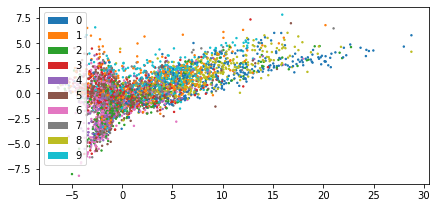

In [100]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [101]:
# # shift = (torch.tensor(cifar_train.targets) == 9).float().unsqueeze(1) * torch.tensor([0.,-10.]) #+ (torch.tensor(cifar_train.targets) == 4).float().unsqueeze(1) * torch.tensor([8.,0.])
# # shifted_train = projected_train + shift
# shift = (torch.tensor(cifar_train.targets) == 5).float().unsqueeze(1) * torch.tensor([-5.,5.]) + (torch.tensor(cifar_train.targets) == 4).float().unsqueeze(1) * torch.tensor([-5.,2.])
# shifted_train = projected_train + shift

In [102]:
import numpy as np


labels_train = np.array(cifar_train.targets)
shifted_train = projected_train.clone()

for i in range(10):
    shifted_train[labels_train == i] = (1./2. * projected_train[(labels_train == i)] + 1./4. * projected_train[(labels_train == i)].mean(axis=0)) + torch.tensor([0.,0])

In [103]:
# shifted_train[labels_train == 3] += torch.tensor([-7.,0.])

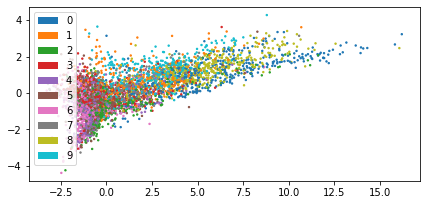

In [104]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [105]:
epochs = 4

In [106]:
cifar_train_for_loader = []
for data, target in trainloader_noshuffle:
    cifar_train_for_loader.append(data)
cifar_train_for_loader = torch.cat(cifar_train_for_loader)

In [107]:
shifted_dataset = torch.utils.data.TensorDataset(cifar_train_for_loader, shifted_train, torch.tensor(cifar_train.targets))
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [108]:
# train network using the altered embedded points
net = Net2()
net.load_state_dict(torch.load('models/cifar-before-ep04.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    train_altered(200, net, 'cpu', shifted_loader, ptsne, optimizer, epoch, 0.5) # 'cuda'

torch.save(net.state_dict(), 'models/cifar-new-after.pt')

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.314920
Train Epoch: 0 [10000/50000 (20%)]	Loss: 0.307594
Train Epoch: 0 [20000/50000 (40%)]	Loss: 0.182907
Train Epoch: 0 [30000/50000 (60%)]	Loss: 0.361935
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.244002
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.269783
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.268944
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.179899
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.249314
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.179952
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.179875
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.286992
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.320352
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.160676
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.181703
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.270571
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.269686
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.293434
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.214764
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.174628


In [38]:
# train network as usual, for better comparability

net = Net2()
net.load_state_dict(torch.load('models/cifar-before-ep04.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    train(200, net, 'cpu', trainloader, optimizer, criterion, epoch) # 'cuda'

torch.save(net.state_dict(), 'models/cifar-new-after-baseline.pt')

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.722219
Train Epoch: 0 [10000/50000 (20%)]	Loss: 0.474940
Train Epoch: 0 [20000/50000 (40%)]	Loss: 0.729389
Train Epoch: 0 [30000/50000 (60%)]	Loss: 0.743109
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.740941
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.697320
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.439024
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.376623
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.720643
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.560608
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.747185
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.573743
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.760216
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.837773
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.566211
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.689814
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.529798
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.423969
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.311672
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.389469


In [127]:
net.load_state_dict(torch.load('models/cifar-new-after.pt'))
net.eval()
with torch.no_grad():
    new_projected_train = []
    new_logits_train = []
    for data, targets in trainloader_noshuffle:
        out = net(data) # data.cuda())
        new_logits_train.append(out.detach().cpu())
        new_projected_train.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    new_projected_train = torch.cat(new_projected_train)
    new_logits_train = torch.cat(new_logits_train)
    
    new_projected_test = []
    new_logits_test = []
    for data, targets in testloader:
        out = net(data) # data.cuda())
        new_logits_test.append(out.detach().cpu())
        new_projected_test.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    new_projected_test = torch.cat(new_projected_test)
    new_logits_test = torch.cat(new_logits_test)

In [128]:
net.load_state_dict(torch.load('models/cifar-new-after-baseline.pt'))
net.eval()
with torch.no_grad():
    projected_test = []
    logits_test = []
    for data, targets in testloader:
        out = net(data) # data.cuda())
        logits_test.append(out.detach().cpu())
        projected_test.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
projected_test = torch.cat(projected_test)
logits_test = torch.cat(logits_test)

# Evaluation

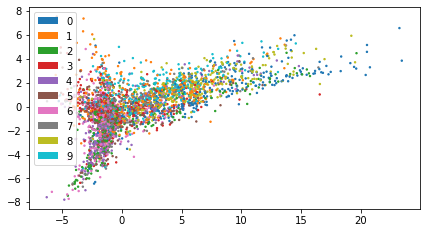

In [129]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(projected_test[::3,0], projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

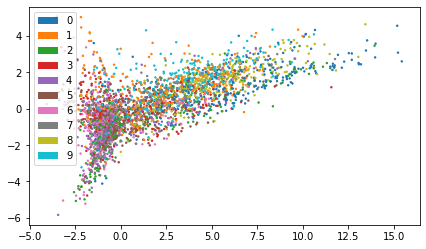

In [130]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(new_projected_test[::3,0], new_projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [113]:
# cf_train = torch.zeros(10,10, dtype=int)
# for i in zip(cifar_train.targets, logits_train.argmax(dim=1)):
#     cf_train[i] += 1

cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, logits_test.argmax(dim=1)):
    cf_test[i] += 1

In [114]:
new_cf_train = torch.zeros(10,10, dtype=int)
for i in zip(cifar_train.targets, new_logits_train.argmax(dim=1)):
    new_cf_train[i] += 1

new_cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, new_logits_test.argmax(dim=1)):
    new_cf_test[i] += 1

In [115]:
# baseline accuracy
cf_test.diag().sum().float() / cf_test.sum().float()

tensor(0.7519)

In [116]:
# intervention accuracy
new_cf_test.diag().sum().float() / new_cf_test.sum().float()

tensor(0.7703)

In [117]:
cf_test

tensor([[730,  11,  46,  36,  26,   4,   7,   7,  96,  37],
        [  8, 884,   2,   8,   3,   0,  11,   1,  25,  58],
        [ 55,   5, 564, 103,  85,  66,  87,  11,  13,  11],
        [ 11,   5,  39, 647,  44, 148,  69,  16,  14,   7],
        [  7,   3,  40,  81, 729,  35,  59,  36,   9,   1],
        [  8,   0,  28, 181,  27, 688,  31,  27,   4,   6],
        [  3,   3,  19,  74,  16,  20, 857,   2,   4,   2],
        [  9,   3,  23,  63,  68,  81,  14, 730,   4,   5],
        [ 30,  25,   8,  24,   4,   4,   5,   2, 872,  26],
        [ 23,  73,   5,  16,   3,   6,  11,   8,  37, 818]])

In [118]:
new_cf_test # class 3 (cat) has the lowest f1 score; it gets confused with classes 4 (deer) and 5 (dog) -> TODO: move points of class 3 away in latent space

tensor([[773,  14,  66,  19,  21,   3,   4,  17,  63,  20],
        [ 23, 877,   5,   8,   3,   3,   6,   3,  22,  50],
        [ 50,   4, 674,  40,  69,  51,  57,  35,  14,   6],
        [ 20,   5,  79, 568,  50, 157,  48,  46,  15,  12],
        [  9,   1,  57,  48, 750,  23,  42,  58,  10,   2],
        [  7,   2,  56, 109,  31, 711,  20,  56,   7,   1],
        [  4,   1,  48,  41,  25,  30, 829,  11,  10,   1],
        [ 14,   4,  22,  24,  41,  45,   7, 835,   5,   3],
        [ 44,  17,  12,  11,   5,   5,   3,   6, 874,  23],
        [ 32,  70,   8,  10,   4,   7,   9,  20,  28, 812]])

In [119]:
def prec(cf, l):
    return cf[l,l].float() / cf[:,l].sum().float()
def rec(cf, l):
    return cf[l,l].float() / cf[l,:].sum().float()
def f1(cf, l):
    return 2 * prec(cf, l) * rec(cf, l) / (prec(cf, l) + rec(cf, l))

In [120]:
# print(cf_test[1,1].float() / cf_test[:,1].sum().float()) # precision 'Auto'
# print(cf_test[1,1].float() / cf_test[1,:].sum().float()) # recall

# print(cf_test[9,9].float() / cf_test[:,9].sum().float()) # precision 'Truck'
# print(cf_test[9,9].float() / cf_test[9,:].sum().float()) # recall

print(prec(cf_test, 3))
print(rec(cf_test, 3))
print(f1(cf_test, 3))

tensor(0.5247)
tensor(0.6470)
tensor(0.5795)


In [121]:
# print(new_cf_test[1,1].float() / new_cf_test[:,1].sum().float()) # precision 'Auto'
# print(new_cf_test[1,1].float() / new_cf_test[1,:].sum().float()) # recall

# print(new_cf_test[9,9].float() / new_cf_test[:,9].sum().float()) # precision 'Truck'
# print(new_cf_test[9,9].float() / new_cf_test[9,:].sum().float()) # recall

print(prec(new_cf_test, 3))
print(rec(new_cf_test, 3))
print(f1(new_cf_test, 3))

tensor(0.6469)
tensor(0.5680)
tensor(0.6049)


In [122]:
cifar_test.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [123]:
from sklearn.metrics import f1_score
f1_score(cifar_test.targets, logits_test.argmax(dim=1), average=None)

array([0.77494692, 0.87872763, 0.63585118, 0.57948948, 0.72718204,
       0.6705653 , 0.79683868, 0.79347826, 0.83926853, 0.83003551])

In [124]:
from sklearn.metrics import f1_score
f1_score(cifar_test.targets, new_logits_test.argmax(dim=1), average=None)

array([0.78238866, 0.87919799, 0.6650222 , 0.60489883, 0.75037519,
       0.6987715 , 0.81876543, 0.80019166, 0.85351562, 0.84145078])